In [ ]:
# Import all the necessary packages
import os
import xarray as xr
import numpy as np
import pandas as pd

from ark.utils import spatial_analysis_utils, io_utils # noqa: E402
from ark.analysis import spatial_analysis, visualize

import ark.settings as settings

In [ ]:
# This script takes a cell expression matrix, label maps for the fovs to be included in the analysis, and, depending
# on the analysis, a threshold matrix for channel or cluster spatial analysis. In channel spatial analysis, cells for
# a specific fov are identified, and cells of particular phenotypes are compared to each other to check for positive,
# negative, or no enrichment. To do this, a distance matrix is created from the label_maps, cell phenotypes are
# identified by their labels in the image and then significant interactions between different populations of phenotypes
# are recorded. Similar analysis is also done for channel spatial enrichment; however, instead of looking at cell
# phenotypes, markers positive for specific thresholds are identified and specific interactions are then characterized
# between them.

In [ ]:
# Set up file paths and import data
base_dir = "../data/example_dataset/"
spatial_analysis_dir = os.path.join(base_dir, "spatial_enrichment_input_data")

In [ ]:
# validate file paths (add other directories as needed)
io_utils.validate_paths([
    base_dir,
    spatial_analysis_dir,
])

In [ ]:
# Import the necessary data
# This is the cell expression matrix including data for fovs 6 and 7, their cell labels, marker expression,
# cell phenotypes, and cell phenotype IDs.
all_data = pd.read_csv(os.path.join(spatial_analysis_dir, "example_expression_matrix.csv"))

In [ ]:
# This is the threshold matrix with all marker thresholds - for channel cpatial enrichment
marker_thresholds = pd.read_csv(os.path.join(spatial_analysis_dir, "markerThresholds.csv"))
marker_thresholds = marker_thresholds.drop(0, axis=0)

In [ ]:
# This is the Xarray of label maps for multiple fovs from which the distance matrix will be computed
label_maps = xr.load_dataarray(os.path.join(spatial_analysis_dir, "segmentation_labels.xr"))

# Get dictionary object with the respective distance matrices for the fovs
dist_mats = spatial_analysis_utils.calc_dist_matrix(label_maps)

In [ ]:
# Columns, other than the marker columns, in the expression data
# These columns will be excluded from the analysis, so that a matrix of only markers can be extracted
excluded_channels = [
    "C",
    "Na",
    "Si",
    "Background",
    "HH3",
    "Ta",
    "Au",
]

In [ ]:
# Now run the distance matrix, threshold values, and the expression matrix through
# channel spatial enrichment

values_channel, stats_channel = spatial_analysis.calculate_channel_spatial_enrichment(
    dist_mats, marker_thresholds, all_data, excluded_channels, bootstrap_num=5)

In [ ]:
# Now with the same parameters, cluster spatial analysis (based on cell types rather than positive marker expression
# by thresholds) will be done

values_cluster, stats_cluster = spatial_analysis.calculate_cluster_spatial_enrichment(
    all_data, dist_mats, bootstrap_num=5)

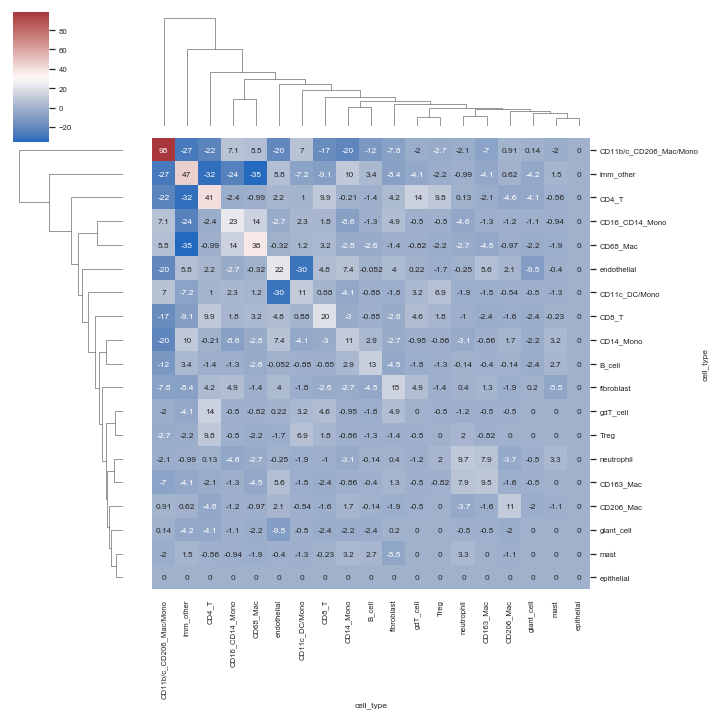

In [11]:
# To visualize the z scores, a clustermap can be produced
# For cluster spatial analysis, first find all the cell phenotypes in the data to use as an input for the clustergram
pheno_titles = all_data["cell_type"].drop_duplicates()
visualize.draw_heatmap(stats_cluster.loc['fov6', "z", :, :].values, pheno_titles, pheno_titles)

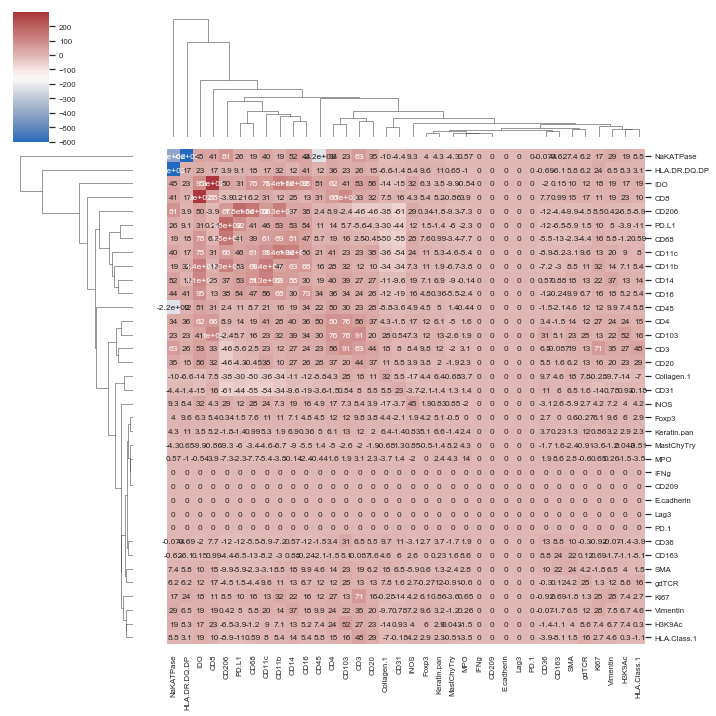

In [12]:
# For channel spatial analysis, first find all the marker titles to use as input for the clustergram
channel_start = np.where(all_data.columns == settings.PRE_CHANNEL_COL)[0][0] + 1
channel_end = np.where(all_data.columns == settings.POST_CHANNEL_COL)[0][0]

marker_titles = all_data.iloc[:, channel_start:channel_end].drop(excluded_channels, axis=1).columns
visualize.draw_heatmap(stats_channel.loc['fov6', "z", :, :].values, marker_titles, marker_titles)